# Step 1. Importing Library and setting up the environment

In [ ]:
# =======================
# ✅ Basic Environment Setup
# =======================

import sys
import subprocess

def install_packages(packages, description):
    print(f"Installing {description}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + packages.split())
        print(f"{description} installed successfully.")
        return True
    except subprocess.CalledProcessError:
        print(f"Error installing {description}")
        return False

# ---------------------------------------------------------------------------------------------
# Core Libraries Installation
# ---------------------------------------------------------------------------------------------
success = install_packages("web3==6.11.1 pandas numpy matplotlib",
                           "Core data libraries (web3, pandas, numpy, matplotlib)")
if success:
    success = install_packages("plotly seaborn networkx",
                               "Visualization and analysis libraries (plotly, seaborn, networkx)")
if success:
    success = install_packages("kaleido",
                               "Visualization export library")
if success:
    success = install_packages("ipywidgets",
                               "Interactive widgets for notebooks")
if success:
    success = install_packages("eth-utils rlp tqdm graphviz",
                               "Ethereum proof verification libraries")

if success:
    print("All required packages installed successfully!")
else:
    print("Some packages failed to install. Please check the errors above.")

# ---------------------------------------------------------------------------------------------
# Environment Verification
# ---------------------------------------------------------------------------------------------
try:
    # Core data and utility libraries
    import os
    import json
    import time
    import hashlib
    import requests

    # Data analysis stack
    import numpy as np
    import pandas as pd

    # Network and graph analysis
    import networkx as nx

    # Visualization libraries
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Date handling and collections
    from datetime import datetime, timedelta
    from collections import defaultdict, Counter

    # Blockchain interaction libraries
    from web3 import Web3
    from web3.exceptions import TransactionNotFound
    from web3.middleware import geth_poa_middleware
    from hexbytes import HexBytes

    # Google API libraries
    import gspread
    from oauth2client.client import GoogleCredentials
    from oauth2client.service_account import ServiceAccountCredentials

    # Interactive widgets for notebooks
    import ipywidgets as widgets
    from ipywidgets import interact, interactive, fixed, interact_manual

    # Ethereum-specific utilities
    from eth_utils import keccak, to_bytes, to_hex
    import rlp
    from tqdm.notebook import tqdm
    from graphviz import Digraph

    # Setup Plotly default template
    import plotly.io as pio
    pio.templates.default = "plotly_white"

    print("Setup complete! Analytics platform initialized.")
except ImportError as e:
    print(f"Error importing libraries: {e}")


# =======================
# ✅ Example: Fetch Online JSON
# =======================

sanction_list_url = "https://raw.githubusercontent.com/DorkCode/blocked_sanctioned/main/blocked_sanctioned.json"


try:
    response = requests.get(sanction_list_url)
    response.raise_for_status()
    rpc_data = response.json()
    print("✅ JSON data fetched successfully")
except requests.exceptions.HTTPError as http_err:
    print(f"❌ HTTP error occurred: {http_err}")
except ValueError as json_err:
    print(f"❌ JSON decoding error: {json_err}")
except Exception as err:
    print(f"❌ Other error occurred: {err}")

Installing Core data libraries (web3, pandas, numpy, matplotlib)...
Core data libraries (web3, pandas, numpy, matplotlib) installed successfully.
Installing Visualization and analysis libraries (plotly, seaborn, networkx)...
Visualization and analysis libraries (plotly, seaborn, networkx) installed successfully.
Installing Visualization export library...
Visualization export library installed successfully.
Installing Interactive widgets for notebooks...
Interactive widgets for notebooks installed successfully.
Installing Ethereum proof verification libraries...
Ethereum proof verification libraries installed successfully.
All required packages installed successfully!
Setup complete! Analytics platform initialized.
✅ JSON data fetched successfully


# Step 2. Put API key, Project ID and other user specific details

In [ ]:
from web3 import Web3
from web3.middleware import geth_poa_middleware
import google.auth

# ============================================================================
# Config
# ============================================================================

GCP_PROJECT_ID = ""

BLOCKCHAIN_RPC = {
    'ethereum': {
        'holesky': 'https://blockchain.googleapis.com/v1/projects/',
        'mainnet': 'https://blockchain.googleapis.com/v1/projects/',
        'sepolia': 'https://blockchain.googleapis.com/v1/projects/'
    }
}

# ============================================================================
# Initialize Web3 Clients
# ============================================================================

def initialize_web3_clients():
    clients = {}
    for network, rpc_url in BLOCKCHAIN_RPC.get('ethereum', {}).items():
        if not rpc_url or "xxx" in rpc_url.lower() or not rpc_url.startswith("https://"):
            print(f"[{network}] ❌ Invalid or placeholder RPC URL.")
            clients[network] = None
            continue
        try:
            provider = Web3.HTTPProvider(rpc_url, request_kwargs={'timeout': 120})
            w3 = Web3(provider)
            w3.middleware_onion.inject(geth_poa_middleware, layer=0)
            block_num = w3.eth.get_block_number()
            print(f"[{network}] ✅ Connected (Block {block_num})")
            clients[network] = w3
        except Exception as e:
            print(f"[{network}] ❌ Connection failed: {e}")
            clients[network] = None
    return clients

# ============================================================================
# Authenticate with GCP
# ============================================================================

def authenticate_gcp():
    try:
        creds, project_id = google.auth.default()
        print(f"✅ Authenticated with GCP project: {project_id}")
        return creds
    except Exception as e:
        print(f"❌ Failed to authenticate with GCP: {e}")
        return None

# ============================================================================
# Main: Setup Clients
# ============================================================================

# Authenticate and initialize clients
creds = authenticate_gcp()
if creds:
    w3_clients = initialize_web3_clients()
else:
    raise RuntimeError("Authentication failed. Cannot initialize Web3 clients.")

✅ Authenticated with GCP project: 
[holesky] ✅ Connected (Block 3675744)
[mainnet] ✅ Connected (Block 22272973)
[sepolia] ✅ Connected (Block 8122025)


# Step 3. Testing Google RPC

In [ ]:
TARGET_TX_HASH = "0x29f9a47ce732684222ec35f5b9782e28d7ab78af9cc79891d03cb318e31642e0"
TARGET_BLOCK_IDENTIFIER = 22168381  # Can be block number or block hash

# Ensure Web3 clients are available
if 'w3_clients' not in locals() or not isinstance(w3_clients, dict):
    raise NameError("Web3 clients dictionary 'w3_clients' not initialized.")

# Validate and reconnect if needed
w3_mainnet = w3_clients.get('mainnet')
if not w3_mainnet or not w3_mainnet.is_connected():
    w3_clients = initialize_web3_clients()
    w3_mainnet = w3_clients.get('mainnet')
    if not w3_mainnet or not w3_mainnet.is_connected():
        raise ConnectionError("Mainnet Web3 client not connected.")

# Optional testnet setup
w3_testnet = w3_clients.get('sepolia') or w3_clients.get('holesky')
testnet_name = next((name for name in ['sepolia', 'holesky'] if w3_clients.get(name) == w3_testnet), None) if w3_testnet and w3_testnet.is_connected() else None

# --- Validation functions ---
def validate_tx_hash(tx_hash):
    if not isinstance(tx_hash, str) or not tx_hash.startswith("0x") or len(tx_hash) != 66:
        return False, "Invalid transaction hash format"
    try:
        receipt = w3_mainnet.eth.get_transaction_receipt(tx_hash)
        return True, receipt
    except Exception as e:
        return False, f"Transaction not found: {e}"

def validate_block_identifier(block_id):
    try:
        block = w3_mainnet.eth.get_block(block_id)
        return True, block
    except Exception as e:
        return False, f"Block not found: {e}"

# --- Run Validations ---
tx_valid, tx_info = validate_tx_hash(TARGET_TX_HASH)
block_valid, block_info = validate_block_identifier(TARGET_BLOCK_IDENTIFIER)

# --- Summary ---
print("\n🎯 Analysis Targets")
print("────────────────────")
print("Transaction Hash:")
print(f"  ➤ {TARGET_TX_HASH}")
print(f"  ➤ Valid: {tx_valid}")
print(f"  ➤ Info: {tx_info if tx_valid else tx_info}")

print("\nBlock Identifier:")
print(f"  ➤ {TARGET_BLOCK_IDENTIFIER}")
print(f"  ➤ Valid: {block_valid}")
print(f"  ➤ Info: {block_info if block_valid else block_info}")


🎯 Analysis Targets
────────────────────
Transaction Hash:
  ➤ 0x29f9a47ce732684222ec35f5b9782e28d7ab78af9cc79891d03cb318e31642e0
  ➤ Valid: True
  ➤ Info: AttributeDict({'blockHash': HexBytes('0xcb9a85697f9bf7110b7b96baecc7d5d66048540bb428684c99a6a22a6f3177ab'), 'blockNumber': 22168381, 'contractAddress': None, 'cumulativeGasUsed': 10634320, 'effectiveGasPrice': 1399862519, 'from': '0x5d4f7084C4a9780ee0Ae78990995D20737687dA0', 'gasUsed': 45136, 'logs': [AttributeDict({'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'), HexBytes('0x0000000000000000000000005d4f7084c4a9780ee0ae78990995d20737687da0'), HexBytes('0x0000000000000000000000006c3ea9036406852006290770bedfcaba0e23a0e8')], 'data': HexBytes('0x00000000000000000000000000000000000000000000000000000000003d0900'), 'blockNumber': 22168381, 'transactionHash': HexBytes('0x29f9a47ce732684222ec35f5b9782e28d7ab78af9cc79891d03cb318e31642e0'), 'tran

# Step 4. Setting Big Query

In [ ]:
import json
import os
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account

# Paste your Google Service account keys content as a string (with triple quotes to preserve formatting). https://console.cloud.google.com/projectselector2/iam-admin/serviceaccounts?
key_data ={
  "type": "service_account",
  "project_id": "",
  "private_key_id": "",
  "private_key": "",
  "client_email": "",
  "client_id": "",
  "auth_uri": "",
  "token_uri": "",
  "auth_provider_x509_cert_url": "",
  "client_x509_cert_url": "",
  "universe_domain": "googleapis.com"
}





# Create credentials from the dictionary
credentials = service_account.Credentials.from_service_account_info(key_data)

# Create BigQuery client using credentials
bq_client = bigquery.Client(credentials=credentials, project=key_data["project_id"])



# Step 5. Recent PYUSD Transfers Involving Wallet wallet_address on selected_date

In [ ]:

wallet_address = "0x2feab868806dc3492f76b934c49ae8cb14d31261" # Enter wallet address
selected_date = "2025-04-14" # Enter Date in YYYY-MM-DD Format
set_limit = 10 # Set Limit
# Define query
query =f"""
SELECT
    *
FROM
    `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.token_transfers`
WHERE
    (LOWER(from_address) = LOWER('{wallet_address}') OR
     LOWER(to_address) = LOWER('{wallet_address}'))
    AND
    LOWER(address) = LOWER('0x6c3ea9036406852006290770bedfcaba0e23a0e8')
    AND
    DATE(block_timestamp) = DATE '{selected_date}'
ORDER BY
    block_timestamp DESC
LIMIT {set_limit}
"""

# Run query and convert to DataFrame
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# Display
print("📦 BigQuery Results")
print("────────────────────")
if results_df.empty:
    print("No matching token transfers found.")
else:
    from IPython.display import display, HTML

    # Create an HTML title for clarity
    title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Recent PYUSD Transfers Involving Wallet {wallet_address} on {selected_date}</h3>"
    display(HTML(title_html))

    # Enhance the table using Pandas Styler, setting center alignment, borders, and alternating row colors.
    styled_df = (results_df.style
                 # Hide the default DataFrame index column
                 .hide(axis="index")
                 # Set table styles for overall table, header, and data cells
                 .set_table_styles([
                     {
                         'selector': 'table',
                         'props': [
                             ('border-collapse', 'collapse'),
                             ('border', '2px solid black')
                         ]
                     },
                     {
                         'selector': 'th',
                         'props': [
                             ('text-align', 'center'),
                             ('background-color', '#264653'),
                             ('color', 'white'),
                             ('padding', '8px'),
                             ('border', '1px solid black')
                         ]
                     },
                     {
                         'selector': 'td',
                         'props': [
                             ('text-align', 'center'),
                             ('padding', '8px'),
                             ('border', '1px solid black')
                         ]
                     }
                 ])
                 # Ensure all cells' text is centered
                 .set_properties(**{'text-align': 'center'})
                 # Apply alternating row colors for readability
                 .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
                )

    # Set table attributes to center the table itself.
    styled_df = styled_df.set_table_attributes('style="margin-left:auto; margin-right:auto;"')

    # Display the enhanced, centered table
    display(styled_df)


📦 BigQuery Results
────────────────────


block_hash,block_number,block_timestamp,transaction_hash,transaction_index,event_index,batch_index,address,event_type,event_hash,event_signature,operator_address,from_address,to_address,token_id,quantity,removed
0xe6e07a174f02f709ee30ee3b59bb125e2ad73000984b1fafc5f823b6fe63a5ed,22268678,2025-04-14 17:20:23+00:00,0xdc28fb801fc4ec5be72a2b37e6bb455565f0e16b02962ed060543318f51711b1,187,760,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x2feab868806dc3492f76b934c49ae8cb14d31261,0xa7ca2c8673bcfa5a26d8ceec2887f2cc2b0db22a,None,1918140000,False
0xe65143c5c5b7e9036f397649a369b4fa0642e74566fea30f213dddc5727392b2,22267826,2025-04-14 14:28:47+00:00,0x4c9370874fa92d1a23673383936118c75db5ec57e0595b3586ad155cc9ed9043,63,58,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,1349820000,False
0x3c884848a84e8993c7ff544b25a78b8277d1c042ff542fb1e401537d4ceb1752,22267377,2025-04-14 12:58:23+00:00,0xbb617828139f5cdf6b57e6e1b5483f14bd0b186ff0f0d376f476449854f1e6ae,341,754,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,152000000,False
0x3c884848a84e8993c7ff544b25a78b8277d1c042ff542fb1e401537d4ceb1752,22267377,2025-04-14 12:58:23+00:00,0x640f2c436b4c6c037bc98502892f4f64d7773296bde88814a6cb43a45c08aff1,351,788,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,131320000,False
0x3c884848a84e8993c7ff544b25a78b8277d1c042ff542fb1e401537d4ceb1752,22267377,2025-04-14 12:58:23+00:00,0x1d8e65e990e1a98356d2a17aa739c8e25e574492f1311cfaafff31367e9444c5,329,739,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,152000000,False
0xe49b4cc7cc43c99bb3135e57a5c3bc9ff41eb4121b14b6066023b4523050eff5,22267365,2025-04-14 12:55:59+00:00,0xe761655615208c6b7fe5468cd2bc5e46e3aabe0f4b182a9e39d6dcc15a8c0721,337,478,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,76000000,False
0xe49b4cc7cc43c99bb3135e57a5c3bc9ff41eb4121b14b6066023b4523050eff5,22267365,2025-04-14 12:55:59+00:00,0x5fc7aed6d36f8caaa24ee3508090388cef8eca0b3826f2a375d2b51bff32585c,329,475,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,19000000,False
0xe49b4cc7cc43c99bb3135e57a5c3bc9ff41eb4121b14b6066023b4523050eff5,22267365,2025-04-14 12:55:59+00:00,0xbd24bc3ba7c78737b4c616e7ca3afcdb1029852a578f2c2764cc71d88ef8d1bb,331,476,,0x6c3ea9036406852006290770bedfcaba0e23a0e8,ERC-20,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,"Transfer(address,address,uint256)",None,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x2feab868806dc3492f76b934c49ae8cb14d31261,None,38000000,False


# Step 6. Minimum Gas Fee Over a Period of Days

In [ ]:
#enter Details
set_days="1" # Set Number Of Days you want to check the minimum gas
query = f"""
SELECT
  t.hash AS transaction_hash,
  t.from_address,
  t.to_address,
  t.gas_price / 1e9 AS gas_price_gwei,
 block_timestamp  AS timestamp
FROM
  `bigquery-public-data.crypto_ethereum.transactions` t
WHERE
  t.block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {set_days} DAY)
ORDER BY
  gas_price_gwei ASC
LIMIT 1
"""

query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# Display
print("📦 BigQuery Results")
print("────────────────────")
if results_df.empty:
    print("No matching token transfers found.")
else:
    from IPython.display import display, HTML

    # Create an HTML title for clarity
    title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Minimum Gas Fee Over a Period of {set_days} Days</h3>"
    display(HTML(title_html))

    # Enhance the table using Pandas Styler, setting center alignment, borders, and alternating row colors.
    styled_df = (results_df.style
                 # Hide the default DataFrame index column
                 .hide(axis="index")
                 # Set table styles for overall table, header, and data cells
                 .set_table_styles([
                     {
                         'selector': 'table',
                         'props': [
                             ('border-collapse', 'collapse'),
                             ('border', '2px solid black'),
                         ]
                     },
                     {
                         'selector': 'th',
                         'props': [
                             ('text-align', 'center'),
                             ('background-color', '#264653'),
                             ('color', 'white'),
                             ('padding', '8px'),
                             ('border', '1px solid black')
                         ]
                     },
                     {
                         'selector': 'td',
                         'props': [
                             ('text-align', 'center'),
                             ('padding', '8px'),
                             ('border', '1px solid black')
                         ]
                     }
                 ])
                 # Ensure all cells' text is centered
                 .set_properties(**{'text-align': 'center'})
                 # Apply alternating row colors for readability
                 .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
                )

    # Set table attributes to center the table itself.
    styled_df = styled_df.set_table_attributes('style="margin-left:auto; margin-right:auto;"')

    # Display the enhanced, centered table
    display(styled_df)

📦 BigQuery Results
────────────────────


transaction_hash,from_address,to_address,gas_price_gwei,timestamp
0x62e0b314018d6f9a1f053d27a1a23317bfb2925fc166a16a9b433cda560dd183,0xae2fc483527b8ef99eb5d9b44875f005ba1fae13,0x1f2f10d1c40777ae1da742455c65828ff36df387,0.301378,2025-04-15 04:08:47+00:00


# Step 7. Sanction Check

In [ ]:
import json
import os
import logging
import requests
from google.cloud import bigquery
from google.oauth2 import service_account

# Set up basic logging configuration
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# ----------------------------
# Service Account Credentials
# ----------------------------
key_data ={
  "type": "service_account",
  "project_id": "",
  "private_key_id": "",
  "private_key": "",
  "client_email": "",
  "client_id": "",
  "auth_uri": "",
  "token_uri": "",
  "auth_provider_x509_cert_url": "",
  "client_x509_cert_url": "",
  "universe_domain": "googleapis.com"
}


# Create credentials from key_data and initialize BigQuery client using these credentials
credentials = service_account.Credentials.from_service_account_info(key_data)
client = bigquery.Client(credentials=credentials, project=key_data["project_id"])
# ----------------------------
# Blocklist & Query Parameters
# ----------------------------
sanction_list_url = "https://raw.githubusercontent.com/DorkCode/blocked_sanctioned/main/blocked_sanctioned.json"
target_address = "0x361a2f46cBeA98a61E0D7fD6B43C532b11bCcb24"  # Replace with your Ethereum address, e.g., "0x2feab868806dc3492f76b934c49ae8cb14d31261"
days_interval = 2

blocked_wallets_list = []
logging.info(f"Fetching blocklist from: {sanction_list_url}")
try:
    response = requests.get(sanction_list_url, timeout=10)
    response.raise_for_status()
    logging.info("Successfully fetched data. Parsing JSON...")
    data = response.json()

    if isinstance(data, list):
        count_total = len(data)
        blocked_wallets_list = [
            item.get('Address') for item in data
            if isinstance(item, dict) and item.get('Address')
        ]
        blocked_wallets_list = [
            str(addr).strip() for addr in blocked_wallets_list
            if addr and isinstance(addr, str) and addr.strip()
        ]
        count_extracted = len(blocked_wallets_list)
        logging.info(f"Parsed JSON. Total items: {count_total}, Valid addresses extracted: {count_extracted}")
        if count_extracted == 0 and count_total > 0:
            logging.warning("Could not extract any valid addresses. Check JSON structure and 'Address' key.")
    else:
        logging.error(f"Error: Expected a JSON list of dictionaries, but received type {type(data)}")
except requests.exceptions.Timeout:
    logging.error(f"Error: Request timed out while fetching {sanction_list_url}")
except requests.exceptions.RequestException as e:
    logging.error(f"Error fetching URL {sanction_list_url}: {e}")
except json.JSONDecodeError as e:
    logging.error(f"Error decoding JSON from {sanction_list_url}. Content might not be valid JSON. Error: {e}")
except Exception as e:
    logging.error(f"An unexpected error occurred during fetch/parse: {e}")

blocked_wallets_string = ""
if blocked_wallets_list:
    # Format the addresses for BigQuery UNNEST (all addresses lowercased)
    blocked_wallets_string = ",".join([f"'{wallet.lower()}'" for wallet in blocked_wallets_list])
    logging.info(f"Formatted {len(blocked_wallets_list)} addresses for BigQuery.")
else:
    logging.warning("Blocked wallet list is empty or could not be populated. Query will run with an empty blocklist.")


# ----------------------------
# Define the SQL Query
# ----------------------------
sql = f"""
WITH
  blocked_wallets AS (
    SELECT address
    FROM UNNEST([{blocked_wallets_string}]) AS address
  ),
  time_limit AS (
    SELECT TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 2 DAY) AS time_threshold
  )
SELECT
  CASE
    WHEN EXISTS (
      SELECT 1
      FROM `bigquery-public-data.crypto_ethereum.transactions`
      WHERE block_timestamp >= (SELECT time_threshold FROM time_limit)
        AND (
          (LOWER(from_address) = LOWER(CAST(@address AS STRING)) AND LOWER(to_address) IN (SELECT address FROM blocked_wallets))
          OR (LOWER(to_address) = LOWER(CAST(@address AS STRING)) AND LOWER(from_address) IN (SELECT address FROM blocked_wallets))
        )
    )
    THEN 'blocked'
    ELSE 'not blocked'
  END AS interaction_status
"""

# ----------------------------
# Run the Query with Query Parameters
# ----------------------------
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("address", "STRING", target_address.lower()),
    ]
)

if client:
    logging.info(f"Running BigQuery check for address: {target_address} within last {days_interval} days...")
    try:
        query_job = client.query(sql, job_config=job_config)
        logging.info(f"Query Job ID: {query_job.job_id}. Waiting for job to complete...")
        results = query_job.result()
        logging.info("Query completed.")
        for row in results:
             print(f"Interaction Status for {target_address}: {row.interaction_status}")

    except Exception as e:
        logging.error(f"An error occurred during BigQuery query execution: {e}")
        if 'query_job' in locals() and hasattr(query_job, 'errors') and query_job.errors:
            logging.error(f"BigQuery Job Errors: {query_job.errors}")
else:
    logging.error("Cannot run query because BigQuery client initialization failed.")


Interaction Status for 0x361a2f46cBeA98a61E0D7fD6B43C532b11bCcb24: not blocked


# Step 8. Top PYUSD Accounts by Daily Activity

In [ ]:
bq_client = None
try:
    credentials = service_account.Credentials.from_service_account_info(key_data)
    bq_client = bigquery.Client(credentials=credentials, project=key_data["project_id"])
    logging.info(f"BigQuery client initialized successfully for project {key_data['project_id']}.")
except Exception as e:
    logging.error(f"Failed to initialize BigQuery client from service account info: {e}")

# --- The SQL Query (Exactly as provided) ---
sql = """
WITH TransferEvents AS (
  SELECT
    transaction_hash,
    block_timestamp,
    LOWER(CONCAT('0x', SUBSTR(topics[1], 27, 40))) AS from_address,
    LOWER(CONCAT('0x', SUBSTR(topics[2], 27, 40))) AS to_address,
    CAST(CONCAT('0x', SUBSTR(data, 3)) AS FLOAT64) / POW(10, 6) AS amount_pyusd
  FROM
    `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
  WHERE
    address = '0x6c3ea9036406852006290770bedfcaba0e23a0e8' -- PYUSD Contract
    AND topics[SAFE_OFFSET(0)] = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
    AND block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 1 DAY)
),
Incoming AS (
  SELECT
    to_address AS address,
    COUNT(*) AS incoming_transactions,
    SUM(amount_pyusd) AS incoming_pyusd
  FROM TransferEvents
  GROUP BY to_address
),
Outgoing AS (
  SELECT
    from_address AS address,
    COUNT(*) AS outgoing_transactions,
    SUM(amount_pyusd) AS outgoing_pyusd
  FROM TransferEvents
  GROUP BY from_address
)
SELECT
  COALESCE(i.address, o.address) AS address,
  COALESCE(i.incoming_transactions, 0) AS incoming_transactions,
  COALESCE(i.incoming_pyusd, 0) AS incoming_pyusd,
  COALESCE(o.outgoing_transactions, 0) AS outgoing_transactions,
  COALESCE(o.outgoing_pyusd, 0) AS outgoing_pyusd,
  (COALESCE(i.incoming_pyusd, 0) - COALESCE(o.outgoing_pyusd, 0)) AS net_activity,
  RANK() OVER (ORDER BY COALESCE(i.incoming_pyusd, 0) DESC) AS incoming_rank,
  RANK() OVER (ORDER BY COALESCE(o.outgoing_pyusd, 0) DESC) AS outgoing_rank,
  RANK() OVER (ORDER BY (COALESCE(i.incoming_pyusd, 0) - COALESCE(o.outgoing_pyusd, 0)) DESC) AS net_activity_rank
FROM Incoming i
FULL OUTER JOIN Outgoing o
ON i.address = o.address
ORDER BY net_activity DESC
LIMIT 10;
"""

# --- Execute the Query ---
results_df = None # Initialize DataFrame variable
if bq_client: # Check if client was initialized successfully
    logging.info(f"Running the hardcoded BigQuery query...")
    try:
        query_job = bq_client.query(sql) # No job_config needed as query is hardcoded
        logging.info(f"Query Job ID: {query_job.job_id}. Waiting for job to complete...")

        # Wait for the job and fetch results into a Pandas DataFrame
        results_df = query_job.to_dataframe() # Fetch results directly into DataFrame
        logging.info(f"Query completed. Fetched {len(results_df)} rows.")

    except Exception as e:
        logging.error(f"An error occurred during BigQuery query execution: {e}")
        if 'query_job' in locals() and hasattr(query_job, 'errors') and query_job.errors:
            logging.error(f"BigQuery Job Errors: {query_job.errors}")

else:
    logging.error("Cannot run query because BigQuery client initialization failed.")

from IPython.display import display, HTML
import logging

if results_df is not None:
    if not results_df.empty:
        # Create an HTML title for clarity, centered using inline CSS.
        title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Top PYUSD Accounts by Activity</h3>"
        display(HTML(title_html))

        # Enhance the table using Pandas Styler:
        styled_df = (
            results_df.style
            # Hide the default DataFrame index column
            .hide(axis="index")
            # Set table styles for the table, header, and cells
            .set_table_styles([
                {
                    'selector': 'table',
                    'props': [
                        ('border-collapse', 'collapse'),
                        ('border', '2px solid black')
                    ]
                },
                {
                    'selector': 'th',
                    'props': [
                        ('text-align', 'center'),
                        ('background-color', '#264653'),
                        ('color', 'white'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                },
                {
                    'selector': 'td',
                    'props': [
                        ('text-align', 'center'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                }
            ])
            # Ensure that all cell text is centered
            .set_properties(**{'text-align': 'center'})
            # Apply alternating row colors for readability
            .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
            # Center the table using align attribute and margin styling
            .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
        )

        # Display the enhanced, centered table
        display(styled_df)
    else:
        logging.info("Query returned no results.")
else:
    logging.warning("Results DataFrame is None (likely due to query execution error).")



address,incoming_transactions,incoming_pyusd,outgoing_transactions,outgoing_pyusd,net_activity,incoming_rank,outgoing_rank,net_activity_rank
0xfe99644d35926a7955f88eccfa52a13012fa984e,1,20000000.000000,0,0.000000,20000000.000000,3,854,1
0x0349923ae2b35ff4f0099869aeea99d1f3fd12a9,1,5000000.000000,0,0.000000,5000000.000000,12,854,2
0x264bd8291fae1d75db2c5f573b07faa6715997b5,9,31208104.319749,2865,30503311.480000,704792.839749,1,1,3
0x367c42a6f261ec54ffbecf5f41c226be12a3dca0,1,1637177.534588,1,1017754.400000,619423.134588,23,29,4
0x7158e643af99a3a388baee8c812c9129f320d74e,1,424035.078588,0,0.000000,424035.078588,36,854,5
0xf89d7b9c864f589bbf53a82105107622b35eaa40,89,229068.200000,0,0.000000,229068.200000,44,854,6
0x14b21eb12747edf248e83ce179d7c4a6f9ae8e51,1,61783.253209,0,0.000000,61783.253209,53,854,7
0xfa05ad14565437932af42f6f3d000ea988395478,1,49953.973268,0,0.000000,49953.973268,57,854,8
0x383e6b4437b59fff47b619cba855ca29342a8559,5,493319.920053,12,445564.543942,47755.376111,35,38,9
0x7d1ba11f901780e90f2b84b3a0b0214a17d6ecbe,10,36106.077395,0,0.000000,36106.077395,62,854,10


# Step 9. Daily Minimum and Average Gas Fee Over the Last 30 Days

day,min_gas_price_gwei,avg_gas_price_gwei
2025-03-16,0.359302,2.259006
2025-03-17,0.333281,2.391280
2025-03-18,0.338285,2.215525
2025-03-19,0.327392,2.691236
2025-03-20,0.336463,2.215471
2025-03-21,0.335449,1.882264
2025-03-22,0.297528,2.044824
2025-03-23,0.283845,1.641668
2025-03-24,0.306268,2.091352
2025-03-25,0.291333,1.880861


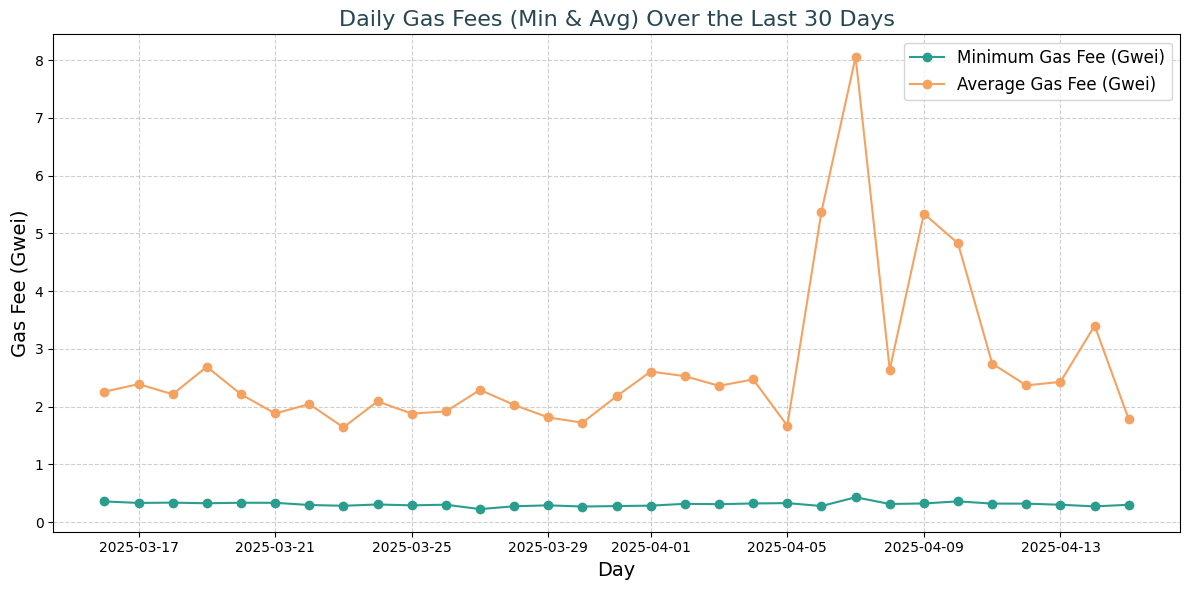

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import logging

# --- Update Details ---
set_days = "30"  # Check the daily gas fees (min & avg) for the last 30 days

# --- Updated Query for Gas Fees (without max fee) ---
query = f"""
SELECT
  DATE(t.block_timestamp) AS day,
  MIN(t.gas_price / 1e9) AS min_gas_price_gwei,
  AVG(t.gas_price / 1e9) AS avg_gas_price_gwei
FROM
  `bigquery-public-data.crypto_ethereum.transactions` t
WHERE
  t.block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {set_days} DAY)
GROUP BY day
ORDER BY day ASC
"""

# Run the query and convert the results into a DataFrame.
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# --- Display Enhanced Table and Graph ---
if results_df is not None:
    if not results_df.empty:
        # Create an HTML title for clarity.
        title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Daily Gas Fees (Min & Avg) Over the Last {set_days} Days</h3>"
        display(HTML(title_html))

        # Enhance the table using Pandas Styler.
        styled_df = (
            results_df.style
            # Hide the default DataFrame index column.
            .hide(axis="index")
            # Set table styles for overall table, header, and data cells.
            .set_table_styles([
                {
                    'selector': 'table',
                    'props': [
                        ('border-collapse', 'collapse'),
                        ('border', '2px solid black')
                    ]
                },
                {
                    'selector': 'th',
                    'props': [
                        ('text-align', 'center'),
                        ('background-color', '#264653'),
                        ('color', 'white'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                },
                {
                    'selector': 'td',
                    'props': [
                        ('text-align', 'center'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                }
            ])
            # Ensure that all cell text is centered.
            .set_properties(**{'text-align': 'center'})
            # Apply alternating row colors for readability.
            .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
            # Center the table using table attributes.
            .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
        )

        # Display the enhanced, centered table.
        display(styled_df)

        # --- Graph Rendering ---
        # Ensure the 'day' column is in datetime format.
        results_df['day'] = pd.to_datetime(results_df['day'])

        # Create the plot for min and avg gas fees.
        plt.figure(figsize=(12, 6))
        plt.plot(results_df['day'], results_df['min_gas_price_gwei'],
                 marker='o', linestyle='-', color='#2a9d8f', label='Minimum Gas Fee (Gwei)')
        plt.plot(results_df['day'], results_df['avg_gas_price_gwei'],
                 marker='o', linestyle='-', color='#f4a261', label='Average Gas Fee (Gwei)')

        # Set title, labels, legend, and grid.
        plt.title(f"Daily Gas Fees (Min & Avg) Over the Last {set_days} Days", fontsize=16, color="#264653")
        plt.xlabel("Day", fontsize=14)
        plt.ylabel("Gas Fee (Gwei)", fontsize=14)
        plt.legend(loc='upper right', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        logging.info("Query returned no results.")
else:
    logging.warning("Results DataFrame is None (likely due to query execution error).")


# Step 10. Daily PYUSD Transaction Count Over Last 30 DAYS

day,tx_count
2025-03-15 00:00:00+00:00,12
2025-03-16 00:00:00+00:00,1508
2025-03-17 00:00:00+00:00,1886
2025-03-18 00:00:00+00:00,2110
2025-03-19 00:00:00+00:00,2878
2025-03-20 00:00:00+00:00,3336
2025-03-21 00:00:00+00:00,3530
2025-03-22 00:00:00+00:00,2935
2025-03-23 00:00:00+00:00,2388
2025-03-24 00:00:00+00:00,3917


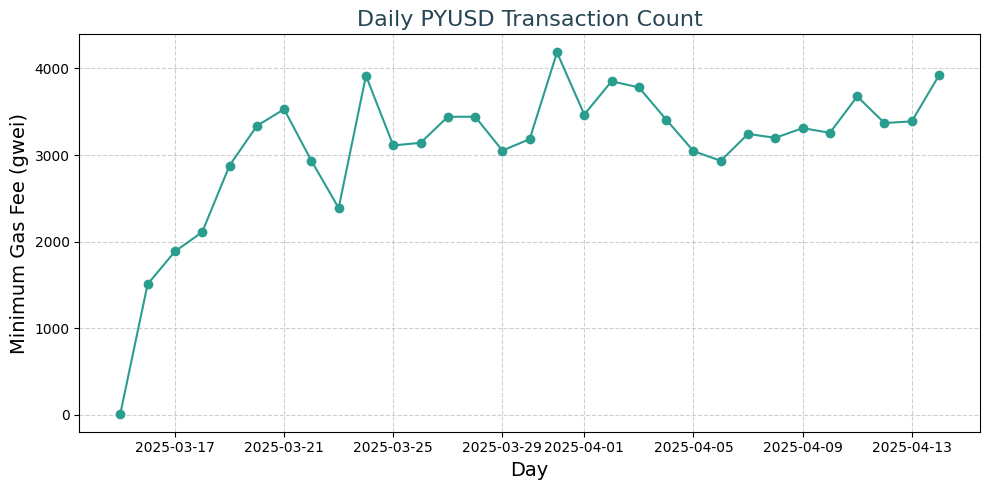

In [ ]:
query = f"""SELECT
  TIMESTAMP_TRUNC(t.block_timestamp, DAY) AS day,
  COUNT(t.transaction_hash) AS tx_count
FROM
  `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.transactions` AS t
WHERE
block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
  AND LOWER(t.to_address) = '0x6c3ea9036406852006290770bedfcaba0e23a0e8'
GROUP BY
  day
ORDER BY
  day ASC
  """
# Run the query and convert the results into a DataFrame.
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# --- Display Enhanced Table and Graph ---
if results_df is not None:
    if not results_df.empty:
        # Create an HTML title for clarity.
        title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Daily PYUSD Transaction Count</h3>"
        display(HTML(title_html))

        # Enhance the table using Pandas Styler.
        styled_df = (
            results_df.style
            # Hide the default DataFrame index column.
            .hide(axis="index")
            # Set table styles for overall table, header, and data cells.
            .set_table_styles([
                {
                    'selector': 'table',
                    'props': [
                        ('border-collapse', 'collapse'),
                        ('border', '2px solid black')
                    ]
                },
                {
                    'selector': 'th',
                    'props': [
                        ('text-align', 'center'),
                        ('background-color', '#264653'),
                        ('color', 'white'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                },
                {
                    'selector': 'td',
                    'props': [
                        ('text-align', 'center'),
                        ('padding', '8px'),
                        ('border', '1px solid black')
                    ]
                }
            ])
            # Ensure that all cell text is centered.
            .set_properties(**{'text-align': 'center'})
            # Apply alternating row colors for readability.
            .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
            # Center the table using table attributes.
            .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
        )

        # Display the enhanced, centered table.
        display(styled_df)

        # --- Graph Rendering ---
        # Ensure the 'day' column is in datetime format.
        results_df['day'] = pd.to_datetime(results_df['day'])

        # Create the plot.
        plt.figure(figsize=(10, 5))
        plt.plot(results_df['day'], results_df['tx_count'],
                 marker='o', linestyle='-', color='#2a9d8f')
        plt.title(f"Daily PYUSD Transaction Count", fontsize=16, color="#264653")
        plt.xlabel("Day", fontsize=14)
        plt.ylabel("Minimum Gas Fee (gwei)", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        logging.info("Query returned no results.")
else:
    logging.warning("Results DataFrame is None (likely due to query execution error).")


# Step 11. Stablecoin Transfer Counts for the Last 30 Days and Their Distribution

token_name,total_transfer_count
USDT,8158958
USDC,6451377
USDe,141935
PYUSD,116719
USD0,62206
TUSD,4174
FUSD,3906


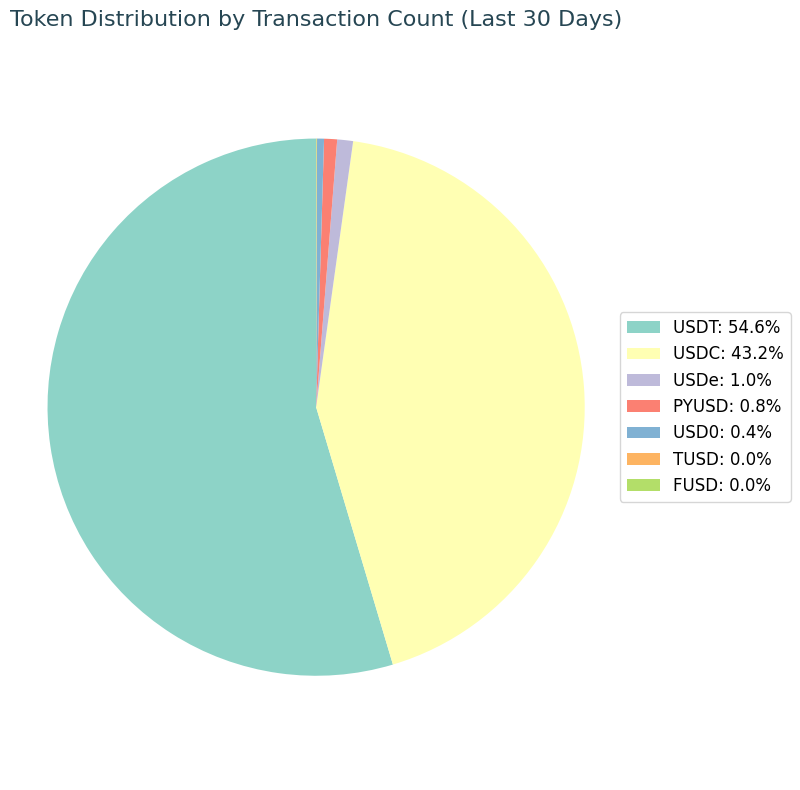

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import logging

# --- New Query to Get Token Transfer Counts for the Last 30 Days ---
query = f"""
WITH TokenMapping AS (
    SELECT
        LOWER('0xdac17f958d2ee523a2206206994597c13d831ec7') AS token_address,
        'USDT' AS token_name
    UNION ALL
    SELECT
        LOWER('0x6c3ea9036406852006290770bedfcaba0e23a0e8') AS token_address,
        'PYUSD' AS token_name
    UNION ALL
    SELECT
        LOWER('0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48') AS token_address,
        'USDC' AS token_name
    UNION ALL
    SELECT
        LOWER('0x4c9edd5852cd905f086c759e8383e09bff1e68b3') AS token_address,
        'USDe' AS token_name
    UNION ALL
    SELECT
        LOWER('0xc5f0f7b66764f6ec8c8dff7ba683102295e16409') AS token_address,
        'FUSD' AS token_name
    UNION ALL
    SELECT
        LOWER('0x0000000000085d4780b73119b644ae5ecd22b376') AS token_address,
        'TUSD' AS token_name
    UNION ALL
    SELECT
        LOWER('0x73a15fed60bf67631dc6cd7bc5b6e8da8190acf5') AS token_address,
        'USD0' AS token_name
),
TotalTransferCountsLast30Days AS (
    SELECT
        tm.token_name,
        COUNT(*) AS total_transfer_count
    FROM
        `bigquery-public-data`.crypto_ethereum.token_transfers AS tt
    JOIN
        TokenMapping AS tm ON LOWER(tt.token_address) = tm.token_address
    WHERE tt.block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL '30' DAY)
    GROUP BY
        tm.token_name
)
SELECT
    token_name,
    total_transfer_count
FROM
    TotalTransferCountsLast30Days
ORDER BY
    total_transfer_count DESC;
"""

# Execute the query and convert the results into a DataFrame.
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# --- Display Enhanced Table and Pie Chart ---
if results_df is not None:
    if not results_df.empty:
        # HTML title for clarity.
        title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>Token Transfer Counts Over the Last 30 Days</h3>"
        display(HTML(title_html))

        # Enhance the table using Pandas Styler.
        styled_df = (
            results_df.style
            .hide(axis="index")
            .set_table_styles([
                {'selector': 'table', 'props': [
                    ('border-collapse', 'collapse'),
                    ('border', '2px solid black')
                ]},
                {'selector': 'th', 'props': [
                    ('text-align', 'center'),
                    ('background-color', '#264653'),
                    ('color', 'white'),
                    ('padding', '8px'),
                    ('border', '1px solid black')
                ]},
                {'selector': 'td', 'props': [
                    ('text-align', 'center'),
                    ('padding', '8px'),
                    ('border', '1px solid black')
                ]}
            ])
            .set_properties(**{'text-align': 'center'})
            .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0
                              else 'background-color: #e9ecef' for _ in x], axis=1)
            .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
        )

        # Display the enhanced table.
        display(styled_df)

        # --- Pie Chart Rendering ---
        sizes = results_df["total_transfer_count"]
        tokens = results_df["token_name"]
        total_count = sizes.sum()

        # Create custom legend labels with percentage values.
        legend_labels = [f"{token}: {count/total_count*100:.1f}%"
                         for token, count in zip(tokens, sizes)]

        plt.figure(figsize=(8, 8))
        # Plot the pie chart without autopct.
        patches, texts = plt.pie(sizes, startangle=90, colors=plt.cm.Set3.colors)
        plt.axis('equal')  # Ensures the pie is drawn as a circle.
        plt.title("Token Distribution by Transaction Count (Last 30 Days)", fontsize=16, color="#264653")

        # Place the legend outside the pie chart.
        plt.legend(patches, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        logging.info("Query returned no results.")
else:
    logging.warning("Results DataFrame is None (likely due to query execution error).")


# Step 12. Stablecoin Transfer Volume for the Last 30 Days and Their Distribution

token_name,total_volume
USDC,627994966999.895508
USDT,276741303970.227966
USDe,14543066806.843981
FUSD,11203544086.927336
PYUSD,4714159466.517650
USD0,2948953299.663909
TUSD,8076875.378708


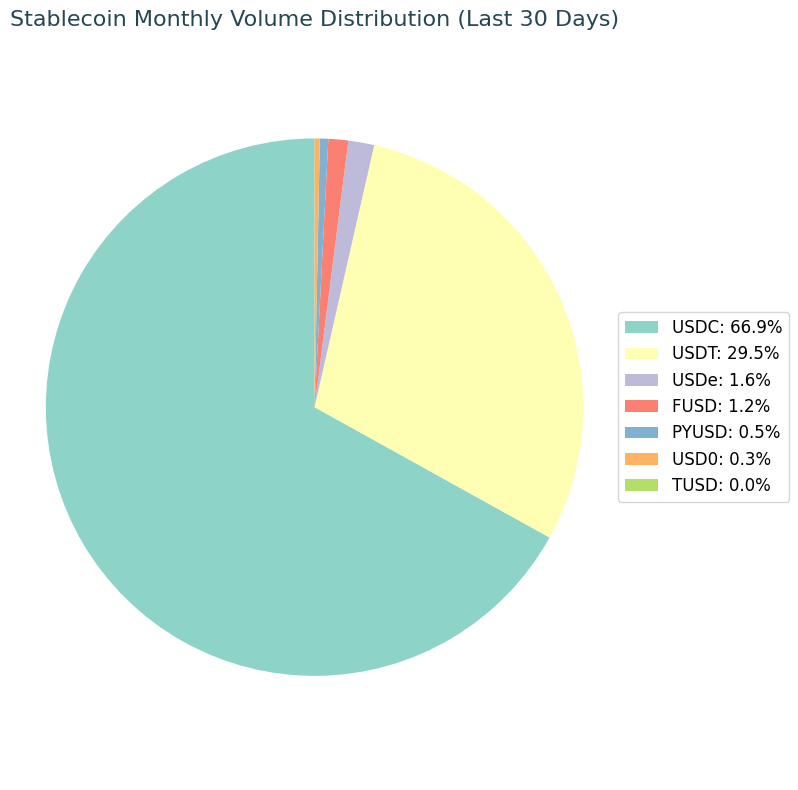

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import logging

# --- Query: Monthly Stablecoin Transfer Volume Over the Last 30 Days ---
query = """
WITH TokenMapping AS (
  SELECT LOWER('0xdac17f958d2ee523a2206206994597c13d831ec7') AS token_address, 'USDT' AS token_name, 6 AS decimals
  UNION ALL
  SELECT LOWER('0x6c3ea9036406852006290770bedfcaba0e23a0e8') AS token_address, 'PYUSD' AS token_name, 6 AS decimals
  UNION ALL
  SELECT LOWER('0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48') AS token_address, 'USDC' AS token_name, 6 AS decimals
  UNION ALL
  SELECT LOWER('0x4c9edd5852cd905f086c759e8383e09bff1e68b3') AS token_address, 'USDe' AS token_name, 18 AS decimals
  UNION ALL
  SELECT LOWER('0xc5f0f7b66764f6ec8c8dff7ba683102295e16409') AS token_address, 'FUSD' AS token_name, 18 AS decimals
  UNION ALL
  SELECT LOWER('0x0000000000085d4780b73119b644ae5ecd22b376') AS token_address, 'TUSD' AS token_name, 18 AS decimals
  UNION ALL
  SELECT LOWER('0x73a15fed60bf67631dc6cd7bc5b6e8da8190acf5') AS token_address, 'USD0' AS token_name, 18 AS decimals
)
SELECT
  tm.token_name,
  SUM(CAST(tt.value AS FLOAT64)) / POW(10, MAX(tm.decimals)) AS total_volume
FROM
  `bigquery-public-data.crypto_ethereum.token_transfers` AS tt
JOIN
  TokenMapping AS tm
  ON LOWER(tt.token_address) = tm.token_address
WHERE
  tt.block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
GROUP BY
  tm.token_name
ORDER BY
  total_volume DESC;
"""

# Execute the query and convert the results into a DataFrame.
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# Ensure the total_volume column is treated as float.
results_df['total_volume'] = results_df['total_volume'].astype(float)

# --- Display Enhanced Table ---
if results_df is not None and not results_df.empty:
    title_html = "<h3 style='color:#2a9d8f; text-align: center;'>Monthly Stablecoin Transfer Volume (Last 30 Days)</h3>"
    display(HTML(title_html))

    styled_df = (
        results_df.style
        .hide(axis="index")
        .set_table_styles([
            {'selector': 'table', 'props': [
                ('border-collapse', 'collapse'),
                ('border', '2px solid black')
            ]},
            {'selector': 'th', 'props': [
                ('text-align', 'center'),
                ('background-color', '#264653'),
                ('color', 'white'),
                ('padding', '8px'),
                ('border', '1px solid black')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'),
                ('padding', '8px'),
                ('border', '1px solid black')
            ]}
        ])
        .set_properties(**{'text-align': 'center'})
        .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0
                          else 'background-color: #e9ecef' for _ in x], axis=1)
        .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
    )

    display(styled_df)

    # --- Pie Chart Rendering ---
    sizes = results_df["total_volume"]
    tokens = results_df["token_name"]
    total_volume = sizes.sum()

    # Create custom legend labels with percentage values.
    legend_labels = [f"{token}: {count/total_volume*100:.1f}%"
                     for token, count in zip(tokens, sizes)]

    plt.figure(figsize=(8, 8))
    patches, texts = plt.pie(sizes, startangle=90, colors=plt.cm.Set3.colors)
    plt.axis('equal')  # Ensures the pie chart is circular.
    plt.title("Stablecoin Monthly Volume Distribution (Last 30 Days)", fontsize=16, color="#264653")

    # Place the legend outside the pie chart.
    plt.legend(patches, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    logging.warning("Results DataFrame is None or empty (likely due to query execution error).")


# Step 13. PYUSD Transactions of a Selected Wallet in Last 30 Days

In [ ]:
from IPython.display import display, HTML
import pandas as pd
import logging
wallet_address = '0x42f7fc4b34ad694721a65e64f952a5553c55f4cf' #Enter wallet Address
# --- Query: Retrieve PYUSD transactions for a specific wallet over the last 30 days ---
query = f"""
SELECT
   LOWER(from_address) AS from_address,
   LOWER(to_address) AS to_address,
   CAST(value AS FLOAT64) / POW(10, 6) AS pyusd_value
FROM
   `bigquery-public-data.crypto_ethereum.token_transfers`
WHERE
   block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
   AND LOWER(token_address) = '0x6c3ea9036406852006290770bedfcaba0e23a0e8'
   AND (
       LOWER(from_address) IN ('{wallet_address.lower()}')
       OR
       LOWER(to_address) IN ('{wallet_address.lower()}')
   )
ORDER BY
   block_timestamp DESC
"""

# Execute the query and convert the results to a DataFrame.
query_job = bq_client.query(query)
results_df = query_job.result().to_dataframe()

# --- Display results in an enhanced table ---
if results_df is not None:
    if not results_df.empty:
        title_html = f"<h3 style='color:#2a9d8f; text-align: center;'>PYUSD Transactions for Wallet {wallet_address} in Last 30 Days</h3>"
        display(HTML(title_html))

        styled_df = (
            results_df.style
            .hide(axis="index")  # Hides the default DataFrame index
            .set_table_styles([
                {'selector': 'table', 'props': [
                    ('border-collapse', 'collapse'),
                    ('border', '2px solid black')
                ]},
                {'selector': 'th', 'props': [
                    ('text-align', 'center'),
                    ('background-color', '#264653'),
                    ('color', 'white'),
                    ('padding', '8px'),
                    ('border', '1px solid black')
                ]},
                {'selector': 'td', 'props': [
                    ('text-align', 'center'),
                    ('padding', '8px'),
                    ('border', '1px solid black')
                ]}
            ])
            .set_properties(**{'text-align': 'center'})
            .apply(lambda x: ['background-color: #f1faee' if x.name % 2 == 0 else 'background-color: #e9ecef' for _ in x], axis=1)
            .set_table_attributes('align="center" style="margin-left:auto; margin-right:auto;"')
        )

        display(styled_df)
    else:
        logging.info("No PYUSD transactions found for the specified wallet in the last 30 days.")
else:
    logging.warning("Results DataFrame is None (likely due to query execution error).")


from_address,to_address,pyusd_value
0x42f7fc4b34ad694721a65e64f952a5553c55f4cf,0x6360a67c68dc3789e4088c58a2bc1a2a6148dfda,20.000000
0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x42f7fc4b34ad694721a65e64f952a5553c55f4cf,20.000000
